In [1]:
import os
os.chdir('../')
from helpers import *

mousenums:  ['230', '355', '358', '362', '673', '674', '816', '825']


In [2]:
# data is df/f data, and o1, o2, c1, and c2 are the time indices in each arm (open and closed)
# method 2
def celltype(data, o1, o2, c1, c2):
    o =np.hstack((o1, o2))
    c = np.hstack((c1, c2))
    r_c1o1 = ranksums(data[c1], data[o1])
    r_c1o2 = ranksums(data[c1], data[o2])
    r_c2o1 = ranksums(data[c2], data[o1])
    r_c2o2 = ranksums(data[c2], data[o2])
    if r_c1o1[0] < 0 and r_c1o1[1] < 0.05 and r_c1o2[0] < 0 and r_c1o2[1] < 0.05:
        if r_c2o1[0] < 0 and r_c2o1[1] < 0.05 and r_c2o2[0] < 0 and r_c2o2[1] < 0.05:
            return 'o'
    if r_c1o1[0] > 0 and r_c1o1[1] < 0.05 and r_c1o2[0] > 0 and r_c1o2[1] < 0.05:
        if r_c2o1[0] > 0 and r_c2o1[1] < 0.05 and r_c2o2[0] > 0 and r_c2o2[1] < 0.05:
            return 'c'
    return 'n'

In [3]:
ct_exit_all = np.zeros((0, 80))
ot_exit_all = np.zeros((0, 80))
nt_exit_all = np.zeros((0, 80))
ct_enter_all = np.zeros((0, 80))
ot_enter_all = np.zeros((0, 80))
nt_enter_all = np.zeros((0, 80))

speeds_enter = np.zeros((0, 80))
speeds_exit = np.zeros((0, 80))

speed_corrs = []
speed_corrs_enter = []
speed_corrs_exit = []

pc_exit_all = np.zeros((0, 80))
pc_enter_all = np.zeros((0, 80))

timeBefore = 40
timeAfter = 40

ctypes_all = []

for mouse in mousenums:
    track, neur, behav = getdicts(foldnames, mouse, 'epm')
    calc = zscore(getcalc(foldnames, mouse, 'epm'))
    
    mpos = track['mouse_positionMS']
    speed = np.linalg.norm(np.diff(mpos, axis = 0), axis = 1)
    speed /= np.max(speed)
    speed = np.hstack((speed, speed[-1]))
    
    length = calc.shape[0]
    isopen = np.zeros(length)
    isopen[behav['openInd']] = 1
    
    # open: 1, closed: -1, center: 0
    arm = np.zeros(neur['C_raw'].shape[0])
    arm[behav['openInd']] = 1
    arm[behav['closedInd']] = -1
    
    ctype = arm[0]
    armInd = [0]
    armType = [ctype]
    for c in range(arm.size):
        if arm[c] != ctype:
            armInd.append(c)
            armType.append(arm[c])
            ctype = arm[c]
    
    exitInd = [] #i.e. enter closed arm
    for i in range(2, len(armInd)):
        if armType[i] == -1:
            if armType[i - 1] == 1:
                exitInd.append(armInd[i])
            elif armType[i - 1] == 0:
                if armType[i - 2] == 1:
                    exitInd.append(armInd[i])
    enterInd = [] #i.e. enter open arm
    for i in range(2, len(armInd)):
        if armType[i] == 1:
            if armType[i - 1] == -1:
                enterInd.append(armInd[i])
            elif armType[i - 1] == 0:
                if armType[i - 2] == -1:
                    enterInd.append(armInd[i])
    
    exitInd = np.asarray(exitInd)
    enterInd = np.asarray(enterInd)
    while exitInd[0] < 40:
        exitInd = exitInd[1:]
    while exitInd[-1] > length - 40:
        exitInd = exitInd[0:-1]
    while enterInd[0] < 40:
        enterInd = enterInd[1:]
    while enterInd[-1] > length - 40:
        enterInd = enterInd[0:-1]
    numCells = calc.shape[1]

    celltypes = ['']*numCells
    for k in range(numCells):
        celltypes[k] = celltype(calc[:, k], behav['o1Ind'].flatten(), behav['o2Ind'].flatten(),
                                behav['c1Ind'].flatten(), behav['c2Ind'].flatten())

    ct_enter = np.zeros((np.sum(np.array(celltypes) == 'c'), enterInd.size, 80))
    ot_enter = np.zeros((np.sum(np.array(celltypes) == 'o'), enterInd.size, 80))
    nt_enter = np.zeros((np.sum(np.array(celltypes) == 'n'), enterInd.size, 80))
    
    pc_enter = np.zeros((enterInd.size, 80))
    
    ci = 0
    oi = 0
    ni = 0
    for cell in range(numCells):
        if celltypes[cell] == 'c':
            for k in range(enterInd.size):
                ct_enter[ci, k] = calc[enterInd[k] - timeBefore:enterInd[k] + timeAfter, cell]
            ci += 1
        if celltypes[cell] == 'o':
            for k in range(enterInd.size):
                ot_enter[oi, k] = calc[enterInd[k] - timeBefore:enterInd[k] + timeAfter, cell]
            oi += 1
        if celltypes[cell] == 'n':
            for k in range(enterInd.size):
                nt_enter[ni, k] = calc[enterInd[k] - timeBefore:enterInd[k] + timeAfter, cell]
            ni += 1
    
    ct_exit = np.zeros((np.sum(np.array(celltypes) == 'c'), exitInd.size, 80))
    ot_exit = np.zeros((np.sum(np.array(celltypes) == 'o'), exitInd.size, 80))
    nt_exit = np.zeros((np.sum(np.array(celltypes) == 'n'), exitInd.size, 80))
    
    pc_exit = np.zeros((exitInd.size, 80))
    
    ci = 0
    oi = 0
    ni = 0
    for cell in range(numCells):
        if celltypes[cell] == 'c':
            for k in range(exitInd.size):
                ct_exit[ci, k] = calc[exitInd[k] - timeBefore:exitInd[k] + timeAfter, cell]
            ci += 1
        if celltypes[cell] == 'o':
            for k in range(exitInd.size):
                ot_exit[oi, k] = calc[exitInd[k] - timeBefore:exitInd[k] + timeAfter, cell]
            oi += 1
        if celltypes[cell] == 'n':
            for k in range(exitInd.size):
                nt_exit[ni, k] = calc[exitInd[k] - timeBefore:exitInd[k] + timeAfter, cell]
            ni += 1
    
    for k in range(enterInd.size):
        speeds_enter = np.vstack((speeds_enter, speed[enterInd[k] - 40:enterInd[k] + 40]))
    for k in range(exitInd.size):
        speeds_exit = np.vstack((speeds_exit, speed[exitInd[k] - 40:exitInd[k] + 40]))
    
    for cell in range(numCells):
        renter = np.zeros(enterInd.size)
        for k in range(enterInd.size):
            r = pearsonr(speed[enterInd[k]-40:enterInd[k]+40], calc[enterInd[k]-40:enterInd[k]+40, cell])[0]
            renter[k] = r
        speed_corrs_enter.append(np.mean(renter))
        rexit = np.zeros(exitInd.size)
        for k in range(exitInd.size):
            r = pearsonr(speed[exitInd[k]-40:exitInd[k]+40], calc[exitInd[k]-40:exitInd[k]+40, cell])[0]
            rexit[k] = r
        speed_corrs_exit.append(np.mean(rexit))
        
        speed_corrs.append(pearsonr(speed, calc[:, cell])[0])
    
    ct_enter_all = np.vstack((ct_enter_all, np.mean(ct_enter, axis = 1)))
    ot_enter_all = np.vstack((ot_enter_all, np.mean(ot_enter, axis = 1)))
    nt_enter_all = np.vstack((nt_enter_all, np.mean(nt_enter, axis = 1)))
    ct_exit_all = np.vstack((ct_exit_all, np.mean(ct_exit, axis = 1)))
    ot_exit_all = np.vstack((ot_exit_all, np.mean(ot_exit, axis = 1)))
    nt_exit_all = np.vstack((nt_exit_all, np.mean(nt_exit, axis = 1)))
    
    pc_enter_all = np.vstack((pc_enter_all, pc_enter))
    pc_exit_all = np.vstack((pc_exit_all, pc_exit))
    
    ctypes_all += celltypes
    

In [4]:
ct_enter_all.shape

(223, 80)

In [5]:
ot_enter_all.shape

(199, 80)

In [6]:
nt_enter_all.shape

(435, 80)

0 Ttest_1sampResult(statistic=-12.175698034329406, pvalue=8.034621300657855e-26)
1 Ttest_1sampResult(statistic=1.043177184067141, pvalue=0.2974469543572119)
2 Ttest_1sampResult(statistic=12.33888765604633, pvalue=5.562285036421767e-27)
RanksumsResult(statistic=-14.044361061359597, pvalue=8.341732264899204e-45)
0 Ttest_1sampResult(statistic=13.702706786736332, pvalue=1.702705479476913e-30)
1 Ttest_1sampResult(statistic=0.6171881816497988, pvalue=0.5374342684206732)
2 Ttest_1sampResult(statistic=-11.730129550632117, pvalue=4.825524860674999e-25)
RanksumsResult(statistic=14.037964722599478, pvalue=9.129710346659763e-45)


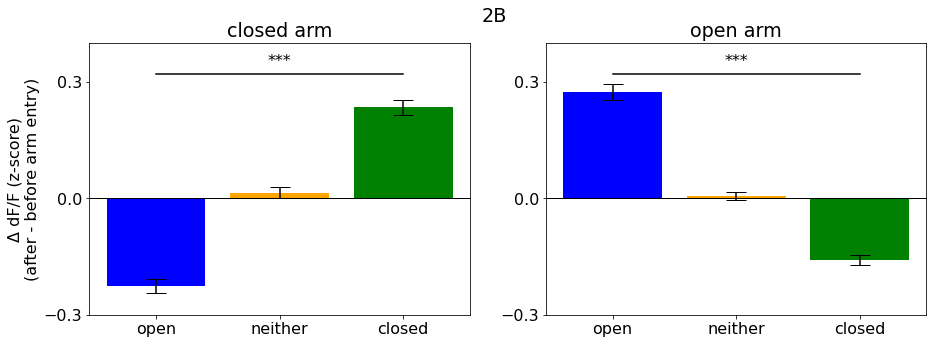

In [7]:
plt.figure(figsize=(15, 5))
colors = ['b', 'orange', 'g']

diffmeans = np.zeros((3, 2))
semmeans = np.zeros((3, 2))

alldiffs = []
plt.subplot(1, 2, 1)
for i, data in enumerate([ot_exit_all, nt_exit_all, ct_exit_all]):
    diffs = np.mean(data[:, 40:59], axis = 1) - np.mean(data[:, 21:40], axis = 1)
    alldiffs.append(diffs)
    plt.bar(i, np.mean(diffs), color = colors[i])
    plt.errorbar(i, np.mean(diffs), sem(diffs), fmt='k_', ms=0, capsize=10)
    
    diffmeans[i, 1] = np.mean(diffs)
    semmeans[i, 1] = sem(diffs)
    
    print(i, ttest_1samp(diffs, 0))
plt.plot(0, 0, 'k_', ms=2000)
plt.xticks([0, 1, 2], ['open', 'neither', 'closed'])
plt.ylim(-0.3, 0.4)
plt.yticks([-0.3, 0, 0.3])
plt.title('closed arm')
print(ranksums(alldiffs[0], alldiffs[2]))
plt.ylabel('Δ dF/F (z-score)\n(after - before arm entry)')
plt.plot([0, 2], [0.32, 0.32], 'k')
plt.text(1, 0.34, '***', ha='center')

alldiffs = []
plt.subplot(1, 2, 2)
for i, data in enumerate([ot_enter_all, nt_enter_all, ct_enter_all]):
    diffs = np.mean(data[:, 40:59], axis = 1) - np.mean(data[:, 21:40], axis = 1)
    alldiffs.append(diffs)
    plt.bar(i, np.mean(diffs), color = colors[i])
    plt.errorbar(i, np.mean(diffs), sem(diffs), fmt='k_', ms=0, capsize=10)
    
    diffmeans[i, 0] = np.mean(diffs)
    semmeans[i, 0] = sem(diffs)
    
    print(i, ttest_1samp(diffs, 0))
plt.plot(0, 0, 'k_', ms=2000)
plt.xticks([0, 1, 2], ['open', 'neither', 'closed'])
plt.title('open arm')
plt.ylim(-0.3, 0.4)
plt.yticks([-0.3, 0, 0.3])
plt.plot([0, 2], [0.32, 0.32], 'k')
plt.text(1, 0.34, '***', ha='center')


print(ranksums(alldiffs[0], alldiffs[2]))

plt.suptitle('2B')
plt.savefig('./elife_figs/2B.svg')

In [8]:
d = {}
d['enter_open_o'] = ot_enter_all
d['enter_open_n'] = nt_enter_all
d['enter_open_c'] = ct_enter_all

d['enter_closed_o'] = ot_exit_all
d['enter_closed_n'] = nt_exit_all
d['enter_closed_c'] = ct_exit_all

In [9]:
d['enter_open_sem_o'] = sem(ot_enter_all, axis=0)
d['enter_open_sem_n'] = sem(nt_enter_all, axis=0)
d['enter_open_sem_c'] = sem(ct_enter_all, axis=0)

d['enter_closed_sem_o'] = sem(ot_exit_all, axis=0)
d['enter_closed_sem_n'] = sem(nt_exit_all, axis=0)
d['enter_closed_sem_c'] = sem(ct_exit_all, axis=0)

In [10]:
ct_exit_all = np.zeros((0, 80))
ot_exit_all = np.zeros((0, 80))
nt_exit_all = np.zeros((0, 80))
ct_enter_all = np.zeros((0, 80))
ot_enter_all = np.zeros((0, 80))
nt_enter_all = np.zeros((0, 80))

speeds_enter = np.zeros((0, 80))
speeds_exit = np.zeros((0, 80))

speed_corrs = []
speed_corrs_enter = []
speed_corrs_exit = []

pc_exit_all = np.zeros((0, 80))
pc_enter_all = np.zeros((0, 80))

timeBefore = 40
timeAfter = 40

ctypes_all = []

for mouse in mousenums:
    track, neur, behav = getdicts(foldnames, mouse, 'epm')
    calc = zscore(getcalc(foldnames, mouse, 'epm'))
    
    mpos = track['mouse_positionMS']
    speed = np.linalg.norm(np.diff(mpos, axis = 0), axis = 1)
    speed /= np.max(speed)
    speed = np.hstack((speed, speed[-1]))
    
    length = calc.shape[0]
    isopen = np.zeros(length)
    isopen[behav['openInd']] = 1
    
    # open: 1, closed: -1, center: 0
    arm = np.zeros(neur['C_raw'].shape[0])
    arm[behav['openInd']] = 1
    arm[behav['closedInd']] = -1
    
    ctype = arm[0]
    armInd = [0]
    armType = [ctype]
    for c in range(arm.size):
        if arm[c] != ctype:
            armInd.append(c)
            armType.append(arm[c])
            ctype = arm[c]
    
    exitInd = [] #i.e. exit open arm
    for i in range(2, len(armInd)):
        if armType[i] == -1:
            if armType[i - 1] == 1:
                exitInd.append(armInd[i-1])
            elif armType[i - 1] == 0:
                if armType[i - 2] == 1:
                    exitInd.append(armInd[i-1])
    enterInd = [] #i.e. exit closed arm
    for i in range(2, len(armInd)):
        if armType[i] == 1:
            if armType[i - 1] == -1:
                enterInd.append(armInd[i-1])
            elif armType[i - 1] == 0:
                if armType[i - 2] == -1:
                    enterInd.append(armInd[i-1])
    
    exitInd = np.asarray(exitInd)
    enterInd = np.asarray(enterInd)
    while exitInd[0] < 40:
        exitInd = exitInd[1:]
    while exitInd[-1] > length - 40:
        exitInd = exitInd[0:-1]
    while enterInd[0] < 40:
        enterInd = enterInd[1:]
    while enterInd[-1] > length - 40:
        enterInd = enterInd[0:-1]
    numCells = calc.shape[1]

    celltypes = ['']*numCells
    for k in range(numCells):
        celltypes[k] = celltype(calc[:, k], behav['o1Ind'].flatten(), behav['o2Ind'].flatten(),
                                behav['c1Ind'].flatten(), behav['c2Ind'].flatten())

    ct_enter = np.zeros((np.sum(np.array(celltypes) == 'c'), enterInd.size, 80))
    ot_enter = np.zeros((np.sum(np.array(celltypes) == 'o'), enterInd.size, 80))
    nt_enter = np.zeros((np.sum(np.array(celltypes) == 'n'), enterInd.size, 80))
    
    pc_enter = np.zeros((enterInd.size, 80))
    
    ci = 0
    oi = 0
    ni = 0
    for cell in range(numCells):
        if celltypes[cell] == 'c':
            for k in range(enterInd.size):
                ct_enter[ci, k] = calc[enterInd[k] - timeBefore:enterInd[k] + timeAfter, cell]
            ci += 1
        if celltypes[cell] == 'o':
            for k in range(enterInd.size):
                ot_enter[oi, k] = calc[enterInd[k] - timeBefore:enterInd[k] + timeAfter, cell]
            oi += 1
        if celltypes[cell] == 'n':
            for k in range(enterInd.size):
                nt_enter[ni, k] = calc[enterInd[k] - timeBefore:enterInd[k] + timeAfter, cell]
            ni += 1
    
    ct_exit = np.zeros((np.sum(np.array(celltypes) == 'c'), exitInd.size, 80))
    ot_exit = np.zeros((np.sum(np.array(celltypes) == 'o'), exitInd.size, 80))
    nt_exit = np.zeros((np.sum(np.array(celltypes) == 'n'), exitInd.size, 80))
    
    pc_exit = np.zeros((exitInd.size, 80))
    
    ci = 0
    oi = 0
    ni = 0
    for cell in range(numCells):
        if celltypes[cell] == 'c':
            for k in range(exitInd.size):
                ct_exit[ci, k] = calc[exitInd[k] - timeBefore:exitInd[k] + timeAfter, cell]
            ci += 1
        if celltypes[cell] == 'o':
            for k in range(exitInd.size):
                ot_exit[oi, k] = calc[exitInd[k] - timeBefore:exitInd[k] + timeAfter, cell]
            oi += 1
        if celltypes[cell] == 'n':
            for k in range(exitInd.size):
                nt_exit[ni, k] = calc[exitInd[k] - timeBefore:exitInd[k] + timeAfter, cell]
            ni += 1
    
    for k in range(enterInd.size):
        speeds_enter = np.vstack((speeds_enter, speed[enterInd[k] - 40:enterInd[k] + 40]))
    for k in range(exitInd.size):
        speeds_exit = np.vstack((speeds_exit, speed[exitInd[k] - 40:exitInd[k] + 40]))
    
    for cell in range(numCells):
        renter = np.zeros(enterInd.size)
        for k in range(enterInd.size):
            r = pearsonr(speed[enterInd[k]-40:enterInd[k]+40], calc[enterInd[k]-40:enterInd[k]+40, cell])[0]
            renter[k] = r
        speed_corrs_enter.append(np.mean(renter))
        rexit = np.zeros(exitInd.size)
        for k in range(exitInd.size):
            r = pearsonr(speed[exitInd[k]-40:exitInd[k]+40], calc[exitInd[k]-40:exitInd[k]+40, cell])[0]
            rexit[k] = r
        speed_corrs_exit.append(np.mean(rexit))
        
        speed_corrs.append(pearsonr(speed, calc[:, cell])[0])
    
    ct_enter_all = np.vstack((ct_enter_all, np.mean(ct_enter, axis = 1)))
    ot_enter_all = np.vstack((ot_enter_all, np.mean(ot_enter, axis = 1)))
    nt_enter_all = np.vstack((nt_enter_all, np.mean(nt_enter, axis = 1)))
    ct_exit_all = np.vstack((ct_exit_all, np.mean(ct_exit, axis = 1)))
    ot_exit_all = np.vstack((ot_exit_all, np.mean(ot_exit, axis = 1)))
    nt_exit_all = np.vstack((nt_exit_all, np.mean(nt_exit, axis = 1)))
    
    pc_enter_all = np.vstack((pc_enter_all, pc_enter))
    pc_exit_all = np.vstack((pc_exit_all, pc_exit))
    
    ctypes_all += celltypes

In [11]:
d['exit_open_o'] = ot_exit_all
d['exit_open_n'] = nt_exit_all
d['exit_open_c'] = ct_exit_all

d['exit_closed_o'] = ot_enter_all
d['exit_closed_n'] = nt_enter_all
d['exit_closed_c'] = ct_enter_all

In [12]:
d['exit_open_sem_o'] = sem(ot_exit_all, axis=0)
d['exit_open_sem_n'] = sem(nt_exit_all, axis=0)
d['exit_open_sem_c'] = sem(ct_exit_all, axis=0)

d['exit_closed_sem_o'] = sem(ot_enter_all, axis=0)
d['exit_closed_sem_n'] = sem(nt_enter_all, axis=0)
d['exit_closed_sem_c'] = sem(ct_enter_all, axis=0)

In [13]:
order_o = np.argsort(np.argmax(d['enter_open_o'], axis = 1))
order_n = np.arange(d['enter_open_n'].shape[0])
order_c = np.argsort(np.argmax(d['enter_closed_c'], axis = 1))
orders = [order_o, order_n, order_c]

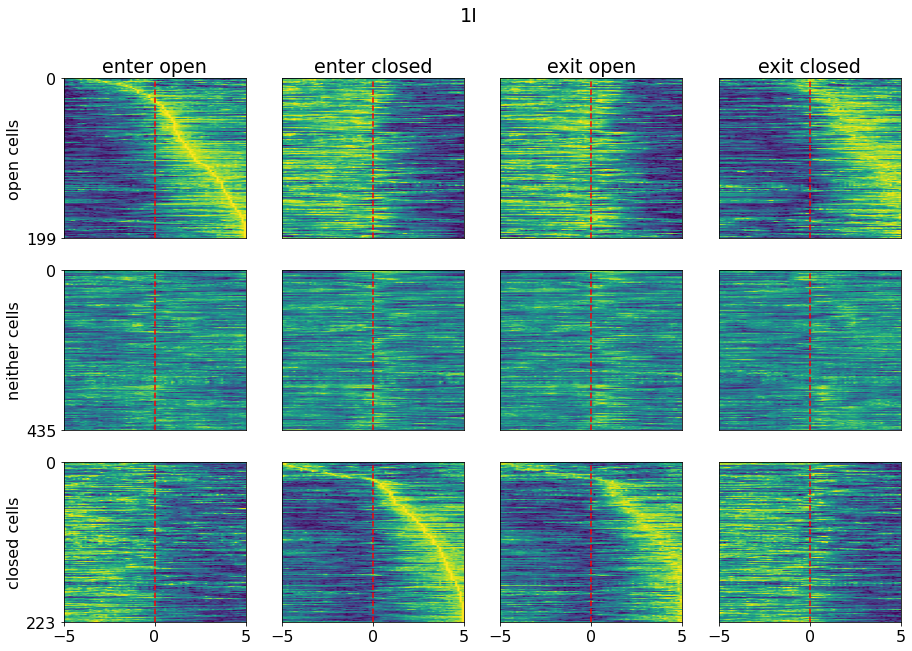

In [14]:
plt.figure(figsize=(15, 10))

titles = ['enter open', 'enter closed', 'exit open', 'exit closed']
ylabels = ['open cells', 'neither cells', 'closed cells']
for i, name in enumerate(['enter_open_', 'enter_closed_', 'exit_open_', 'exit_closed_']):
    for j, typ in enumerate(['o', 'n', 'c']):
        plt.subplot(3, 4, j*4+i+1)
        key = name + typ
        data = d[key][orders[j]]
        data = data.T - np.min(data, axis=1)
        data = (data / np.max(data, axis=0)).T
        plt.imshow(data, aspect='auto', extent=[-5, 5, 0, orders[j].size])
        if j == 2:
            plt.xticks([-5, 0, 5])
        else:
            plt.xticks([])
        if j == 0:
            plt.title(titles[i])
        if i == 0:
            plt.yticks([orders[j].size, 0], [0, orders[j].size])
            plt.ylabel(ylabels[j])
        else:
            plt.yticks([])
        plt.plot([0, 0], [0, orders[j].size], 'r--')
plt.suptitle('1I')
plt.savefig('./elife_figs/1I.svg')

In [15]:
t = np.arange(-timeBefore, timeAfter) / 7.5

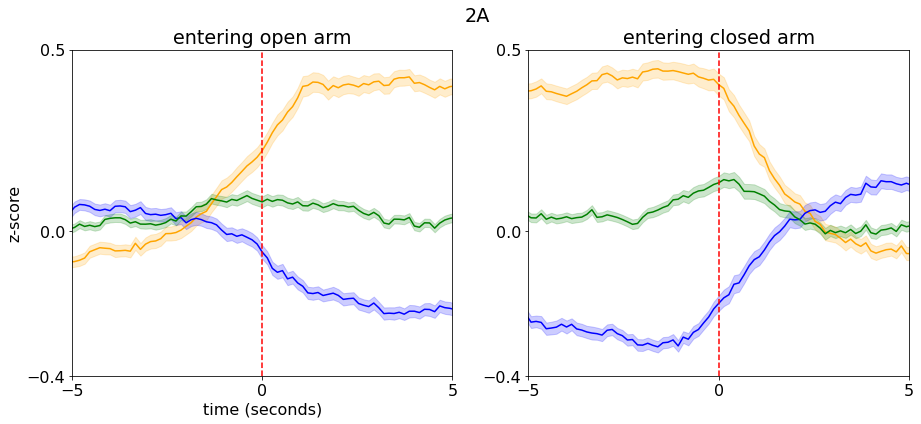

In [16]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(t, np.mean(d['enter_open_o'], axis = 0), c = 'orange')
plt.fill_between(t, np.mean(d['enter_open_o'], axis = 0) - sem(d['enter_open_o'], axis = 0), 
                 np.mean(d['enter_open_o'], axis = 0) + sem(d['enter_open_o'], axis = 0), color = 'orange', alpha = 0.2)
plt.plot(t, np.mean(d['enter_open_c'], axis = 0), c = 'b')
plt.fill_between(t, np.mean(d['enter_open_c'], axis = 0) - sem(d['enter_open_c'], axis = 0), 
                 np.mean(d['enter_open_c'], axis = 0) + sem(d['enter_open_c'], axis = 0), color = 'b', alpha = 0.2)
plt.plot(t, np.mean(d['enter_open_n'], axis = 0), c = 'g')
plt.fill_between(t, np.mean(d['enter_open_n'], axis = 0) - sem(d['enter_open_n'], axis = 0), 
                 np.mean(d['enter_open_n'], axis = 0) + sem(d['enter_open_n'], axis = 0), color = 'g', alpha = 0.2)
plt.ylim([-0.4, 0.5])
plt.xlim(-5, 5)
plt.xticks([-5, 0, 5])
plt.yticks([-0.4, 0, 0.5])
plt.plot([0, 0], plt.ylim(), 'r--')
plt.ylabel('z-score')
plt.xlabel('time (seconds)')
plt.title('entering open arm')

plt.subplot(1, 2, 2)
plt.plot(t, np.mean(d['enter_closed_o'], axis = 0), c = 'orange')
plt.fill_between(t, np.mean(d['enter_closed_o'], axis = 0) - sem(d['enter_closed_o'], axis = 0), 
                 np.mean(d['enter_closed_o'], axis = 0) + sem(d['enter_closed_o'], axis = 0), color = 'orange', alpha = 0.2)
plt.plot(t, np.mean(d['enter_closed_c'], axis = 0), c = 'b')
plt.fill_between(t, np.mean(d['enter_closed_c'], axis = 0) - sem(d['enter_closed_c'], axis = 0), 
                 np.mean(d['enter_closed_c'], axis = 0) + sem(d['enter_closed_c'], axis = 0), color = 'b', alpha = 0.2)
plt.plot(t, np.mean(d['enter_closed_n'], axis = 0), c = 'g')
plt.fill_between(t, np.mean(d['enter_closed_n'], axis = 0) - sem(d['enter_closed_n'], axis = 0), 
                 np.mean(d['enter_closed_n'], axis = 0) + sem(d['enter_closed_n'], axis = 0), color = 'g', alpha = 0.2)
plt.ylim([-0.4, 0.5])
plt.xlim(-5, 5)
plt.xticks([-5, 0, 5])
plt.yticks([-0.4, 0, 0.5])
plt.plot([0, 0], plt.ylim(), 'r--')
plt.title('entering closed arm')

plt.suptitle('2A')
plt.savefig('./elife_figs/2A.svg')